# Importing necessary packages

In [1]:
# !pip install gif2numpy

In [2]:
# !pip install rasterio

In [3]:
import os
from pathlib import Path

import cv2
import gif2numpy
import matplotlib.pyplot as plt
import numpy as np
import yaml
from yaml.loader import SafeLoader

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
import os
os.getcwd()

'C:\\Users\\niloy\\Desktop\\Hackathon'

# Defining necessary constants

In [6]:
DATASET_PATH = Path("./Dataset/aemet/10min")
YAML_PATH = Path("./Dataset/radars.yaml")

root_dir_path = os.getcwd()

PALMA_DATASET_PATH = os.path.join(root_dir_path,DATASET_PATH,'pm')
VALENCIA_DATASET_PATH = os.path.join(root_dir_path,DATASET_PATH,"va")
BARCELONA_DATASET_PATH = os.path.join(root_dir_path,DATASET_PATH,"ba")

# Digitizing the dataset

In [7]:
with open(YAML_PATH, 'r') as f:
    data = yaml.load(f, Loader=SafeLoader)

In [8]:
palma_location_data = data["data"]["PM"]
valencia_location_data = data["data"]["VA"]
barcelona_location_data = data["data"]["BA"]
barcelona_location_data

{'rdr_code': 'ba',
 'latitude': 41.4082,
 'longitude': 1.88499,
 'radius': 240,
 'name': 'Barcelona'}

In [9]:
def create_circular_mask(h, w, center=None, radius=None):
    if center is None:
        center = (int(w/2), int(h/2))
    
    if radius is None:
        radius = min(center[0], center[1], w-center[0], h-center[1])
        
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)
    
    mask = dist_from_center <= radius
    return mask

In [10]:
class LocationData():
    def __init__(self, location_data, gif_path):
        np_frames, _, image_specs = gif2numpy.convert(gif_path)
        self.image = np_frames[0]
        _, dim, _ = self.image.shape
        self.image = self.image[:dim, :, ::-1]
        self.height, self.width, _ = self.image.shape
        
        mask = self._create_circular_mask()
        self.image[~mask] = 0
        
        latitude = float(location_data["latitude"])
        longitude = float(location_data["longitude"])
        
        # Degrees in 1 pixel
        self.lat_diff = 1 / 110.574
        self.long_diff = 1 / (111.320 * np.cos(latitude))
        
    def _create_circular_mask(self):
        center = (int(self.width/2), int(self.height/2))
        radius = min(center[0], center[1], self.width-center[0], self.height-center[1])

        Y, X = np.ogrid[:self.height, :self.width]
        dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)

        mask = dist_from_center <= radius
        return mask

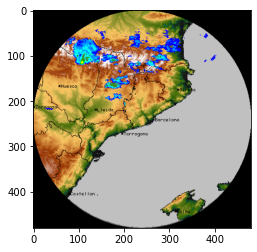

In [11]:
for day_folder_name in sorted(os.listdir(BARCELONA_DATASET_PATH), reverse = True):
    day_folder_path = os.path.join(BARCELONA_DATASET_PATH, day_folder_name)
    for image_name in sorted(os.listdir(day_folder_path)):
        image_path = os.path.join(day_folder_path, image_name)
        
        image_data = LocationData(barcelona_location_data, image_path)
        
        plt.imshow(image_data.image)
        plt.show()
        break
        
    break

In [12]:

palma_image_path = "./Dataset/aemet/10min/pm/20220101/aemet_pm_202201010000.gif"
valencia_image_path = "./Dataset/aemet/10min/va/20220101/aemet_va_202201010000.gif"
barcelona_image_path = "./Dataset/aemet/10min/ba/20220101/aemet_ba_202201010000.gif"

palma_image_data = LocationData(palma_location_data, palma_image_path)
valencia_image_data = LocationData(valencia_location_data, valencia_image_path)
barcelona_image_data = LocationData(barcelona_location_data, barcelona_image_path)

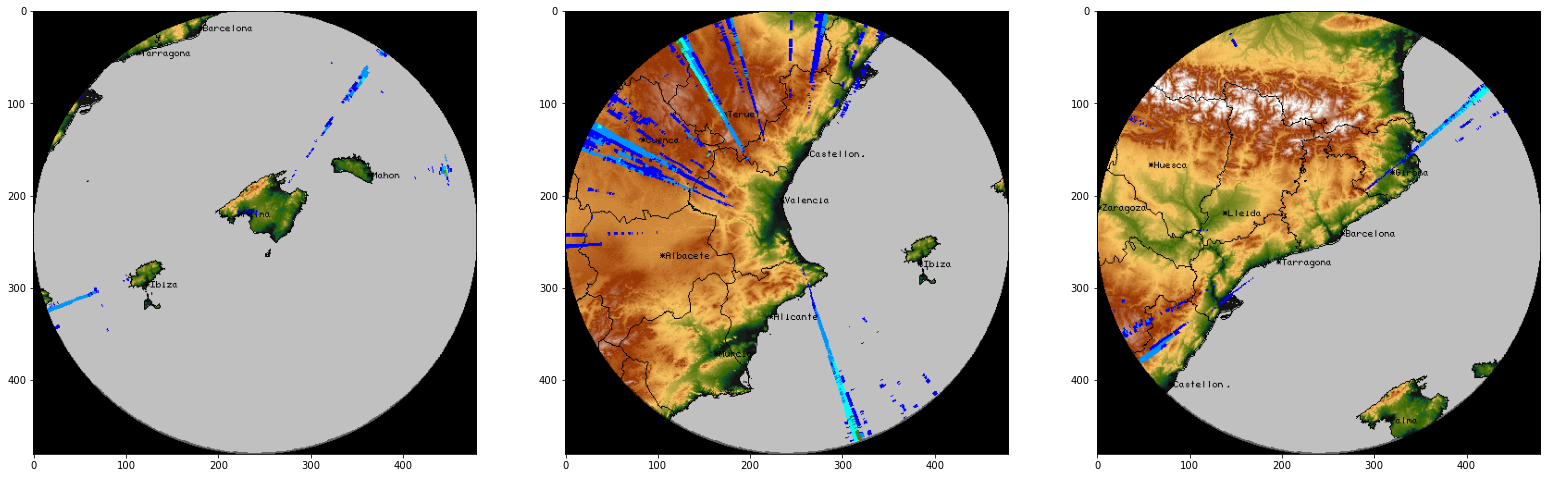

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(27, 9))
ax[0].imshow(palma_image_data.image)
ax[1].imshow(valencia_image_data.image)
ax[2].imshow(barcelona_image_data.image)
plt.show()

In [14]:
palma_image_data.long_diff, valencia_image_data.long_diff, barcelona_image_data.long_diff

(-0.08193207483814463, 0.09609509633959179, -0.010652965851564633)

(480, 480, 3)

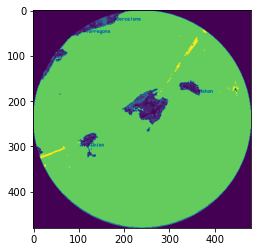

In [15]:
plt.imshow(palma_image_data.image[:, :, 2])
palma_image_data.image.shape

In [16]:
import rasterio

from rasterio.transform import Affine

center_longitude, center_latitude = barcelona_location_data["longitude"], barcelona_location_data["latitude"]
radius = barcelona_location_data["radius"] * 1000

height, width, _ = barcelona_image_data.image.shape

x = np.arange(0, width, 1)
y = np.arange(0, height, 1)

latitudes = center_latitude - (height/2 - y) * 1 / 110.574
longitudes = center_longitude - (width/2 - x) * 1 / (111.320 * np.cos(latitudes * np.pi / 180))

xres = (longitudes[-1] - longitudes[0]) / len(longitudes)
yres = (latitudes[-1] - latitudes[0]) / len(latitudes)

transform = Affine.translation(longitudes[0] - xres/2, latitudes[0] - yres/2) * Affine.scale(xres, yres)

with rasterio.open(
    "./barcelona.tif",
    mode='w',
    driver="GTiff",
    height=height,
    width=width,
    count=3,
    dtype=barcelona_image_data.image.dtype,
    crs="+proj=latlong",
    transform=transform
) as f:
    f.write(barcelona_image_data.image[:, :, 0], 1)
    f.write(barcelona_image_data.image[:, :, 1], 2)
    f.write(barcelona_image_data.image[:, :, 2], 3)

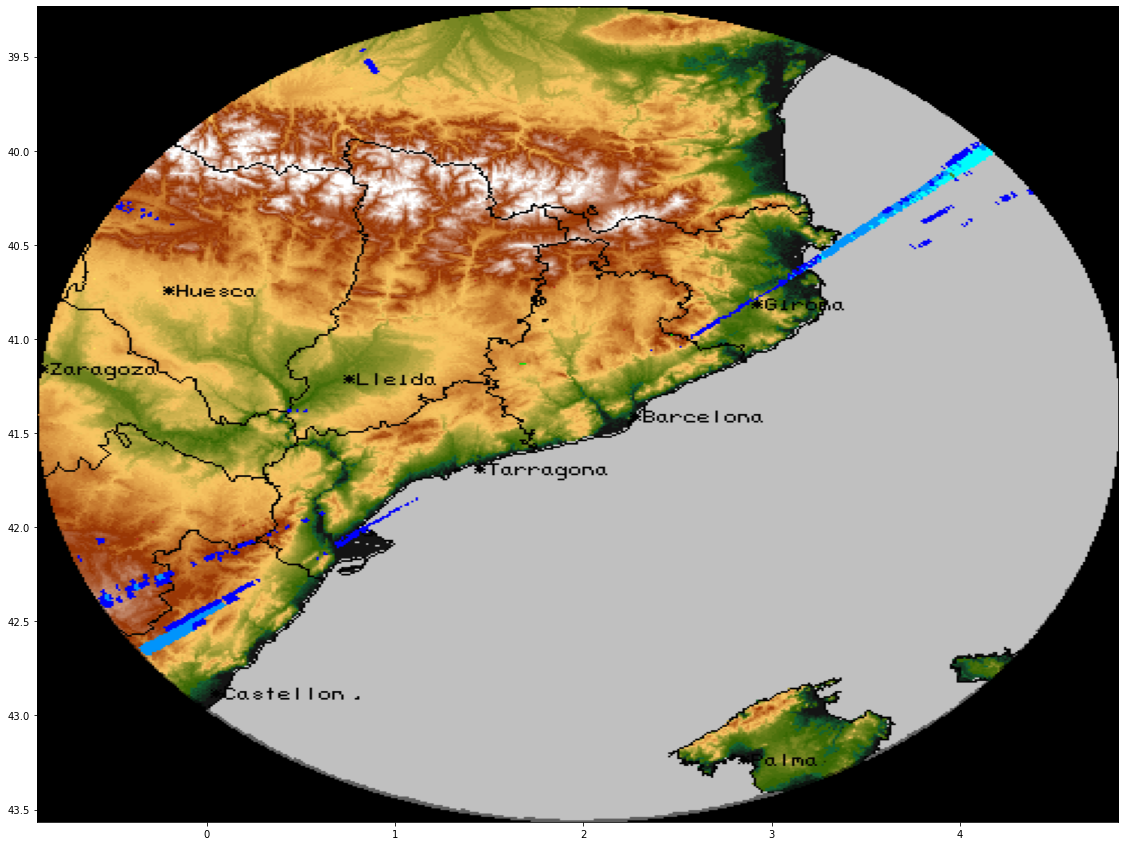

<AxesSubplot:>

In [17]:
from rasterio.plot import show

raster = rasterio.open("./barcelona.tif")

fig, ax = plt.subplots(1, figsize=(20, 15))
show((raster.read()), transform=raster.transform)

In [18]:
# !pip install tensorflow

In [19]:
import pathlib
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
import numpy as np
import cv2
import skimage
from skimage.util import random_noise
import tensorflow as tf
from skimage.transform import resize

from tqdm.notebook import tqdm
import random

In [20]:
def get_images_paths(root_dir_ssid):

  noisy_lst= []

  for day_folder_name in sorted(os.listdir(root_dir_ssid)):
    if day_folder_name.startswith('.'):
      continue
    if day_folder_name[4:6] == "03":
      break
    day_folder_path = os.path.join(root_dir_ssid, day_folder_name)
    for image_name in sorted(os.listdir(day_folder_path)):
      image_path = os.path.join(day_folder_path, image_name)
      noisy_lst.append(str(os.path.abspath(image_path)))


  # # Getting mi dataset images
  # root = pathlib.Path(root_dir_mi)
  # img_paths = list(root.rglob("*.bmp*"))
  # img_paths_lst = [str(path) for path in img_paths]

  # for p in img_paths_lst:
  #     img_type = p.split("/")[-1].split('_')[-1]
  #     if "Noisy" in img_type:
  #         noisy_lst.append(p)
  #     elif "Reference" in img_type:
  #         gt_lst.append(p)
  #         gt_lst.append(p)


  # # Getting NIND dataset images
  # root = pathlib.Path(root_dir_nind)
  # img_paths = list(root.rglob("*.png*"))
  # img_paths.extend(list(root.rglob("*.jpg*")))
  # img_paths_lst = [str(path) for path in img_paths]

  # for p in img_paths_lst:
  #     img_type = p.split("/")[-1].split("_")[-1]
  #     if "H" in img_type:
  #         noisy_lst.append(p)
  #     else:
  #         gt_lst.append(p)

  noisy_array = np.asarray(noisy_lst)
  # gt_lst = os.path.join(os.path.dirname(root_dir_ssid),'ba_gt')
  gt_lst = "./aemet_ba_202201010610.gif"
  gt_lst = np.asarray(gt_lst)
  return noisy_array, gt_lst

In [21]:
from sklearn.model_selection import train_test_split

noisy_array_paths, gt_array_paths = get_images_paths(BARCELONA_DATASET_PATH)

noisy_train_paths, noisy_test_paths = train_test_split(noisy_array_paths, test_size=0.20, random_state=42)

In [22]:
type(gt_array_paths.item())

str

In [23]:
# Get gt_images in memory
def get_images_in_mem(images_paths):
  images_lst = []
  for img_path in tqdm(images_paths):
    np_frames, _, image_specs = gif2numpy.convert(img_path)
    image = np_frames[0]
    _, dim, _ = image.shape
    image = image[:dim, :, ::-1]
    height, width, _ = image.shape
    mask = create_circular_mask(height, width)
    image[~mask] = 0
    image_resized = resize(image, (256,256))
    images_lst.append(image_resized)
  return np.array(images_lst)

In [24]:
noisy_train_images = get_images_in_mem(noisy_train_paths[:100])
noisy_test_images = get_images_in_mem(noisy_test_paths[101:120])

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

In [25]:
gt_string = gt_array_paths.item()
gt_array_paths = []
for i in range(noisy_train_images.shape[0]):
  gt_array_paths.append(gt_string)
gt_train_images = get_images_in_mem(gt_array_paths)
gt_array_paths = []
for i in range(noisy_test_images.shape[0]):
  gt_array_paths.append(gt_string)
gt_test_images = get_images_in_mem(gt_array_paths)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

In [26]:
print(noisy_train_images.shape)
print(noisy_test_images.shape)
print(gt_train_images.shape)
print(gt_test_images.shape)

(100, 256, 256, 3)
(19, 256, 256, 3)
(100, 256, 256, 3)
(19, 256, 256, 3)


In [27]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2381454340796765524
xla_global_id: -1
]


In [28]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


# REDNet Algorithm

In [29]:
def _up_down_flip(image, label):
    image = tf.image.flip_up_down(image)
    label = tf.image.flip_up_down(label)
    return image, label

def _left_right_flip(image, label):
    image = tf.image.flip_left_right(image)
    label = tf.image.flip_left_right(label)
    return image, label

def _rotate(image, label):
    random_angle = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, random_angle)
    label = tf.image.rot90(label, random_angle)
    return image, label

def _hue(image, label):
    rand_value = random.uniform(-1,1)
    image = tf.image.adjust_hue(image, rand_value)
    label = tf.image.adjust_hue(label, rand_value)
    return image, label

def _brightness(image, label):
    rand_value = random.uniform(-0.08,0.25)
    image = tf.image.adjust_brightness(image, rand_value)
    label = tf.image.adjust_brightness(label, rand_value)
    return image, label

def _saturation(image, label):
    rand_value = random.uniform(1, 5)
    image = tf.image.adjust_saturation(image, rand_value)
    label = tf.image.adjust_saturation(label, rand_value)
    return image, label

def _contrast(image, label):
    rand_value = random.uniform(1, 3)
    image = tf.image.adjust_contrast(image, rand_value)
    label = tf.image.adjust_contrast(label, rand_value)
    return image, label

# What does batch, repeat, and shuffle do with TensorFlow Dataset?
# https://stackoverflow.com/q/53514495/7697658
def tf_data_generator(X, y, batch_size=4, augmentations=None):
    dataset = tf.data.Dataset.from_tensor_slices((X, y)) # This is the main step for data generation
    dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)

    if augmentations:
        for f in augmentations:
            if np.random.uniform(0,1)<0.5:
                dataset = dataset.map(f, num_parallel_calls=2)

    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size=batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

BATCH_SIZE=4
augmentation_lst = [_up_down_flip, _left_right_flip, _rotate]
image_generator_train = tf_data_generator(X=noisy_train_images, y=gt_train_images, batch_size=BATCH_SIZE, augmentations=augmentation_lst)
image_generator_test = tf_data_generator(X=noisy_test_images, y=gt_test_images, batch_size=BATCH_SIZE)

In [30]:
image_generator_train

<PrefetchDataset element_spec=(TensorSpec(shape=(4, 256, 256, 3), dtype=tf.float64, name=None), TensorSpec(shape=(4, 256, 256, 3), dtype=tf.float64, name=None))>

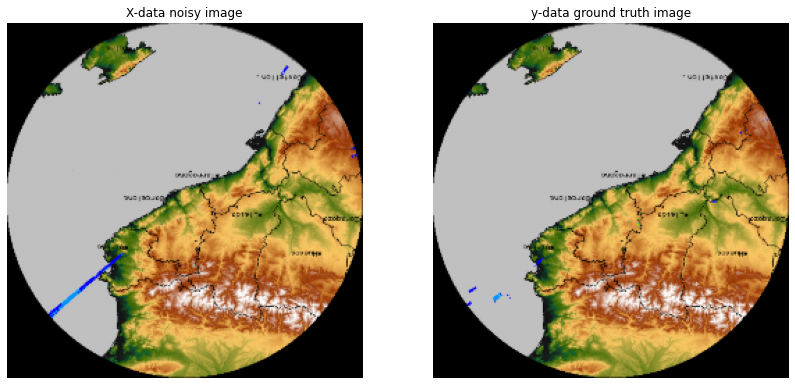

In [31]:
# SANITY CHECK of the Dataset generator
for noisy, gt in image_generator_train.take(1):  # only take first element of dataset
    numpy_images = noisy.numpy()
    numpy_labels = gt.numpy()

f, axarr = plt.subplots(1,2, figsize=(14,14))
axarr[0].imshow(numpy_images[1])
axarr[0].set_title("X-data noisy image")
axarr[0].set_axis_off()

axarr[1].imshow(numpy_labels[1])
axarr[1].set_title("y-data ground truth image")
axarr[1].set_axis_off()

In [32]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Activation, Flatten, Dense, Input, Add
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.optimizers import Adam

In [33]:
def create_model():
    tf.keras.backend.clear_session()

    input_0 = Input(shape=(256,256,3), name="input_layer")
    conv_layer_1 = Conv2D(filters=256, kernel_size=2, padding='same', name="conv_1")(input_0)
    conv_layer_2 = Conv2D(filters=256, kernel_size=2, padding='same', name="conv_2")(conv_layer_1)
    conv_layer_3 = Conv2D(filters=256, kernel_size=3, padding='same', name="conv_3")(conv_layer_2)
    conv_layer_4 = Conv2D(filters=256, kernel_size=3, padding='same', name="conv_4")(conv_layer_3)
    conv_layer_5 = Conv2D(filters=128, kernel_size=3, padding='same', name="conv_5")(conv_layer_4)

    deconv_layer_5 = Conv2DTranspose(filters=256, kernel_size=2, padding='same', name="deconv_5")(conv_layer_5)
    deconv_layer_5 = Add(name="add_1")([conv_layer_4, deconv_layer_5])
    deconv_layer_4 = Conv2DTranspose(filters=256, kernel_size=2, padding='same', name="deconv_4")(deconv_layer_5)
    deconv_layer_3 = Conv2DTranspose(filters=256, kernel_size=3, padding='same', name="deconv_3")(deconv_layer_4)
    deconv_layer_3 = Add(name="add_2")([conv_layer_2, deconv_layer_3])
    deconv_layer_2 = Conv2DTranspose(filters=128, kernel_size=3, padding='same', name="deconv_2")(deconv_layer_3)
    deconv_layer_1 = Conv2DTranspose(filters=3, kernel_size=3, padding='same', name="deconv_1")(deconv_layer_2)
    out = Add(name="add_3")([input_0, deconv_layer_1])

    model = Model(inputs=[input_0], outputs=[out])
    return model

In [34]:
model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1 (Conv2D)                (None, 256, 256, 25  3328        ['input_layer[0][0]']            
                                6)                                                                
                                                                                                  
 conv_2 (Conv2D)                (None, 256, 256, 25  262400      ['conv_1[0][0]']                 
                                6)                                                            

In [35]:
# !pip install pydot

In [36]:
# !pip install pydotplus

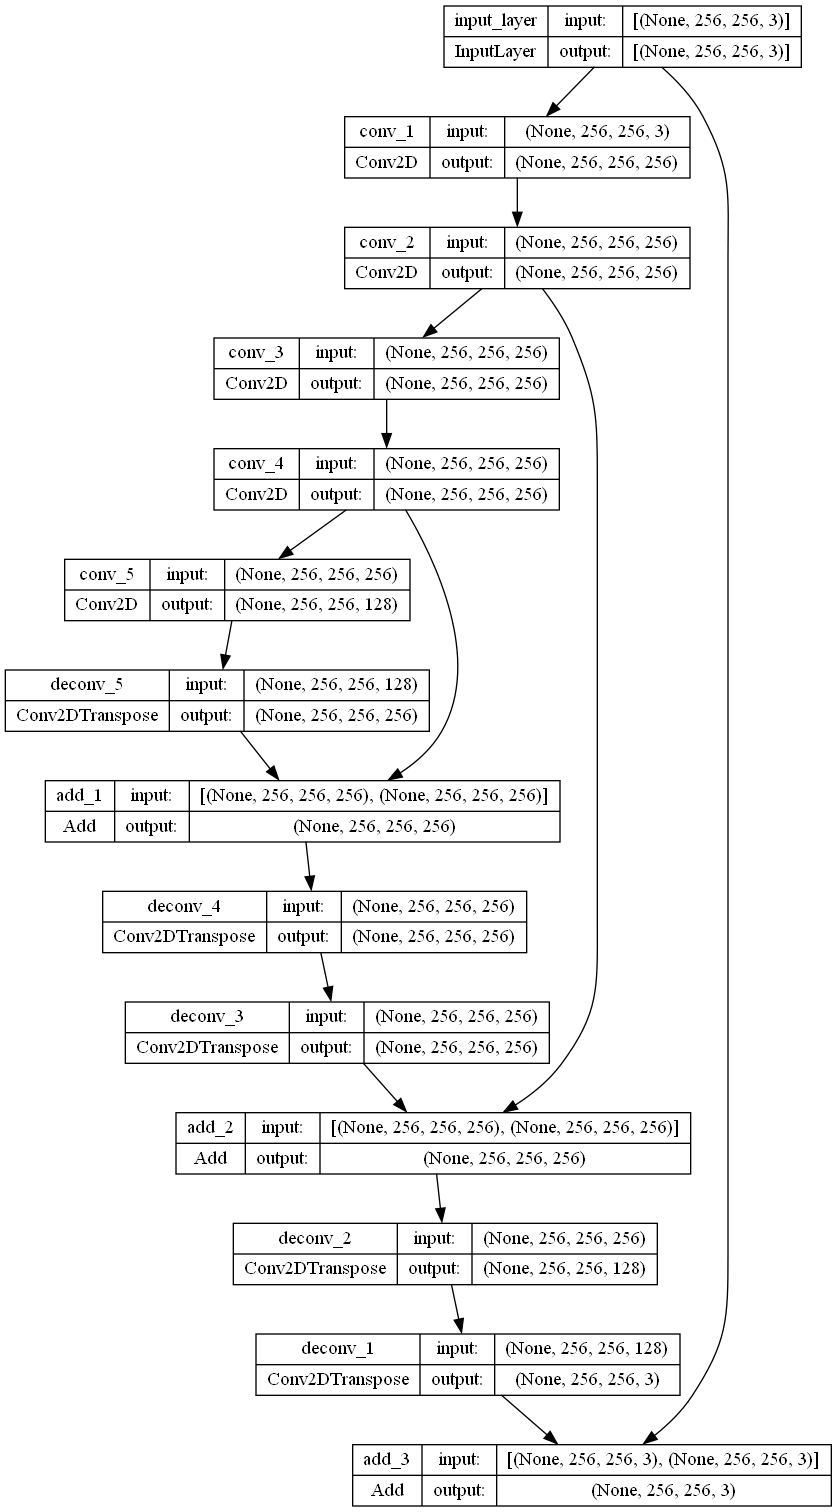

In [37]:
tf.keras.utils.plot_model(model=model, to_file='model_plot.png', show_shapes=True)

# Training

In [38]:
steps_per_epoch_train = len(noisy_train_images)
steps_per_epoch_validation = len(noisy_test_images)

In [39]:
best_models_path = "models/"
callbacks_lst = [
    tf.keras.callbacks.ModelCheckpoint(filepath=best_models_path+"best_REDNet_blindnoise_256x256.h5", period=10, save_weights_only=False),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=0.000009, min_delta=0.0001, factor=0.75, patience=3, verbose=1, mode='min'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, min_delta=0.0001, patience=10)
]

In [40]:
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=Adam(learning_rate=0.0001))

In [41]:
model.fit(image_generator_train, 
          validation_data=image_generator_test,
                        steps_per_epoch=steps_per_epoch_train,
                        validation_steps=steps_per_epoch_validation,
                        epochs=20,
                        verbose=1,
                        callbacks=callbacks_lst)

Epoch 1/20
 17/100 [====>.........................] - ETA: 11:59 - loss: 0.1052

KeyboardInterrupt: 

# PRIDNet

In [34]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose,\
                                    GlobalAveragePooling2D, AveragePooling2D, MaxPool2D, UpSampling2D,\
                                    BatchNormalization, Activation, Flatten, Dense, Input,\
                                    Add, Multiply, Concatenate, concatenate, Softmax
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import softmax

tf.keras.backend.set_image_data_format('channels_last')

In [35]:
class Convolutional_block(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same')
        self.conv_2 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same')
        self.conv_3 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same')
        self.conv_4 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same')

    def call(self, X):
        X_1 = self.conv_1(X)
        X_1 = Activation('relu')(X_1)

        X_2 = self.conv_2(X_1)
        X_2 = Activation('relu')(X_2)

        X_3 = self.conv_3(X_2)
        X_3 = Activation('relu')(X_3)

        X_4 = self.conv_4(X_3)
        X_4 = Activation('relu')(X_4)
        
        #print('---conv block=',X_4.shape)
        
        return X_4

In [36]:
class Channel_attention(tf.keras.layers.Layer):
    def __init__(self, C=64, **kwargs):
        super().__init__(**kwargs)
        self.C=C
        self.gap = GlobalAveragePooling2D()
        self.dense_middle = Dense(units=2, activation='relu')
        self.dense_sigmoid = Dense(units=self.C, activation='sigmoid')
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'C': self.C
        })
        return config

    def call(self, X):
        v = self.gap(X)
        #print("ca_ after gap =",v.shape)
        fc1 = self.dense_middle(v)
        #print("ca_ after fc1 =",fc1.shape)
        mu = self.dense_sigmoid(fc1)
        #print("ca_ after fc2 =",mu.shape)

        U_out = Multiply()([X, mu])
        
        #print('---channel attention block=',U_out.shape)

        return U_out

In [37]:
class Avg_pool_Unet_Upsample_msfe(tf.keras.layers.Layer):
    def __init__(self, avg_pool_size, upsample_rate, **kwargs):
        super().__init__(**kwargs)
        # ---initialization for Avg pooling---
        self.avg_pool = AveragePooling2D(pool_size=avg_pool_size, padding='same')

        # --- initialization for Unet---
        self.deconv_lst = []
        filter=512
        for i in range(4):
            self.deconv_lst.append(Conv2DTranspose(filters=filter/2, kernel_size=[3, 3], strides=2, padding='same'))
            filter/=2

        self.conv_32_down_lst = []
        for i in range(4):
            self.conv_32_down_lst.append(Conv2D(filters=64, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_64_down_lst = []
        for i in range(4):
            self.conv_64_down_lst.append(Conv2D(filters=128, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_128_down_lst = []
        for i in range(4):
            self.conv_128_down_lst.append(Conv2D(filters=256, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_256_down_lst = []
        for i in range(4):
            self.conv_256_down_lst.append(Conv2D(filters=512, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_512_down_lst = []
        for i in range(4):
            self.conv_512_down_lst.append(Conv2D(filters=1024, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))


        self.conv_32_up_lst = []
        for i in range(3):
            self.conv_32_up_lst.append(Conv2D(filters=64, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_64_up_lst = []
        for i in range(3):
            self.conv_64_up_lst.append(Conv2D(filters=128, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_128_up_lst = []
        for i in range(3):
            self.conv_128_up_lst.append(Conv2D(filters=256, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_256_up_lst = []
        for i in range(3):
            self.conv_256_up_lst.append(Conv2D(filters=512, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))


        self.conv_3 = Conv2D(filters=3, kernel_size=[1, 1])

        self.pooling1_unet = MaxPool2D(pool_size=[2, 2], padding='same')
        self.pooling2_unet = MaxPool2D(pool_size=[2, 2], padding='same')
        self.pooling3_unet = MaxPool2D(pool_size=[2, 2], padding='same')
        self.pooling4_unet = MaxPool2D(pool_size=[2, 2], padding='same')

        # ---initialization for Upsampling---
        self.upsample = UpSampling2D(upsample_rate, interpolation='bilinear')
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'avg_pool_size': self.avg_pool_size,
            'upsample_rate':self.upsample_rate
        })
        return config

    def upsample_and_concat(self, x1, x2, i):
        deconv = self.deconv_lst[i](x1)
        deconv_output = Concatenate()([deconv, x2])
        return deconv_output

    def unet(self, input):
        # ---Unet downsampling---
        conv1 = input
        for c_32 in self.conv_32_down_lst:
            conv1 = c_32(conv1)
        pool1 = self.pooling1_unet(conv1)

        conv2 = pool1
        for c_64 in self.conv_64_down_lst:
            conv2 = c_64(conv2)
        pool2 = self.pooling2_unet(conv2)

        conv3 = pool2
        for c_128 in self.conv_128_down_lst:
            conv3 = c_128(conv3)
        pool3 = self.pooling3_unet(conv3)

        conv4 = pool3
        for c_256 in self.conv_256_down_lst:
            conv4 = c_256(conv4)
        pool4 = self.pooling4_unet(conv4)

        conv5 = pool4
        for c_512 in self.conv_512_down_lst:
            conv5 = c_512(conv5)

        # ---Unet upsampling---
        up6 = self.upsample_and_concat(conv5, conv4, 0)
        conv6 = up6
        for c_256 in self.conv_256_up_lst:
            conv6 = c_256(conv6)

        up7 = self.upsample_and_concat(conv6, conv3, 1)
        conv7 = up7
        for c_128 in self.conv_128_up_lst:
            conv7 = c_128(conv7)

        up8 = self.upsample_and_concat(conv7, conv2, 2)
        conv8 = up8
        for c_64 in self.conv_64_up_lst:
            conv8 = c_64(conv8)

        up9 = self.upsample_and_concat(conv8, conv1, 3)
        conv9 = up9
        for c_32 in self.conv_32_up_lst:
            conv9 = c_32(conv9)

        conv10 = self.conv_3(conv9)
        return conv10

    def call(self, X):
        avg_pool = self.avg_pool(X)
        #print("ap =",avg_pool.shape)
        unet = self.unet(avg_pool)
        upsample = self.upsample(unet)
        return upsample

In [38]:
class Multi_scale_feature_extraction(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.msfe_16 = Avg_pool_Unet_Upsample_msfe(avg_pool_size=16, upsample_rate=16)
        self.msfe_8 = Avg_pool_Unet_Upsample_msfe(avg_pool_size=8, upsample_rate=8)
        self.msfe_4 = Avg_pool_Unet_Upsample_msfe(avg_pool_size=4, upsample_rate=4)
        self.msfe_2 = Avg_pool_Unet_Upsample_msfe(avg_pool_size=2, upsample_rate=2)
        self.msfe_1 = Avg_pool_Unet_Upsample_msfe(avg_pool_size=1, upsample_rate=1)

    def call(self, X):
        up_sample_16 = self.msfe_16(X)
        up_sample_8 = self.msfe_8(X)
        up_sample_4 = self.msfe_4(X)
        up_sample_2 = self.msfe_2(X)
        up_sample_1 = self.msfe_1(X)
        msfe_out = Concatenate()([X, up_sample_16, up_sample_8, up_sample_4, up_sample_2, up_sample_1])

        #print('---Multi scale feature extraction block=',msfe_out.shape)
        return msfe_out

In [39]:
class Kernel_selecting_module(tf.keras.layers.Layer):
    def __init__(self, C=21, **kwargs):
        super().__init__(**kwargs)
        self.C = C
        self.c_3 = Conv2D(filters=self.C, kernel_size=(3,3), strides=1, padding='same', kernel_regularizer=regularizers.l2(l2=0.001))
        self.c_5 = Conv2D(filters=self.C, kernel_size=(5,5), strides=1, padding='same', kernel_regularizer=regularizers.l2(l2=0.001))
        self.c_7 = Conv2D(filters=self.C, kernel_size=(7,7), strides=1, padding='same', kernel_regularizer=regularizers.l2(l2=0.001))
        self.gap = GlobalAveragePooling2D()
        self.dense_two = Dense(units=2, activation='relu')
        self.dense_c1 = Dense(units=self.C)
        self.dense_c2 = Dense(units=self.C)
        self.dense_c3 = Dense(units=self.C)
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'C': self.C
        })
        return config

    def call(self, X):
        X_1 = self.c_3(X)
        X_2 = self.c_5(X)
        X_3 = self.c_7(X)

        X_dash = Add()([X_1, X_2, X_3])

        v_gap = self.gap(X_dash)
        v_gap = tf.reshape(v_gap, [-1, 1, 1, self.C])
        fc1 = self.dense_two(v_gap)

        alpha = self.dense_c1(fc1)
        beta = self.dense_c2(fc1)
        gamma = self.dense_c3(fc1)

        before_softmax = concatenate([alpha, beta, gamma], 1)
        # print(before_softmax.shape)
        after_softmax = softmax(before_softmax, axis=1)
        a1 = after_softmax[:, 0, :, :]
        # print(a1)
        a1 = tf.reshape(a1, [-1, 1, 1, self.C])
        # print(a1)
        a2 = after_softmax[:, 1, :, :]
        a2 = tf.reshape(a2, [-1, 1, 1, self.C])
        a3 = after_softmax[:, 2, :, :]
        a3 = tf.reshape(a3, [-1, 1, 1, self.C])

        select_1 = Multiply()([X_1, a1])
        select_2 = Multiply()([X_2, a2])
        select_3 = Multiply()([X_3, a3])

        out = Add()([select_1, select_2, select_3])

        return out

In [40]:
def create_model():
    # ca_block = Channel Attention block
    # msfe_block = Multi scale feature extraction block
    # ksm = Kernel Selecting Module
    tf.keras.backend.clear_session()

    input = Input(shape=(256,256,3), name="input_layer")
    print("Input =",input.shape)

    conv_block = Convolutional_block()(input)
    print("Conv block =",conv_block.shape)
    ca_block = Channel_attention()(conv_block)
    print("Channel Attention =",ca_block.shape)
    ca_block = Conv2D(filters=3, kernel_size=(3,3), strides=1, padding='same')(ca_block)
    print("Channel Attention Last CNN =",ca_block.shape)
    ca_block = Concatenate()([input, ca_block])
    print("First phase =",ca_block.shape)
    print()

    msfe_block = Multi_scale_feature_extraction()(ca_block)

    print("Multi-scale feature extraction =",msfe_block.shape)

    ksm = Kernel_selecting_module()(msfe_block)
    ksm = Conv2D(filters=3, kernel_size=(3,3), strides=1, padding='same')(ksm)
    print("Kernel Selection Module =",ksm.shape)
    model = Model(inputs=[input], outputs=[ksm])
    return model

model = create_model()
model.summary()

Input = (None, 256, 256, 3)
Conv block = (None, 256, 256, 64)
Channel Attention = (None, 256, 256, 64)
Channel Attention Last CNN = (None, 256, 256, 3)
First phase = (None, 256, 256, 6)

Multi-scale feature extraction = (None, 256, 256, 21)
Kernel Selection Module = (None, 256, 256, 3)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 convolutional_block (Convoluti  (None, 256, 256, 64  112576     ['input_layer[0][0]']            
 onal_block)                    )                                                                 
     

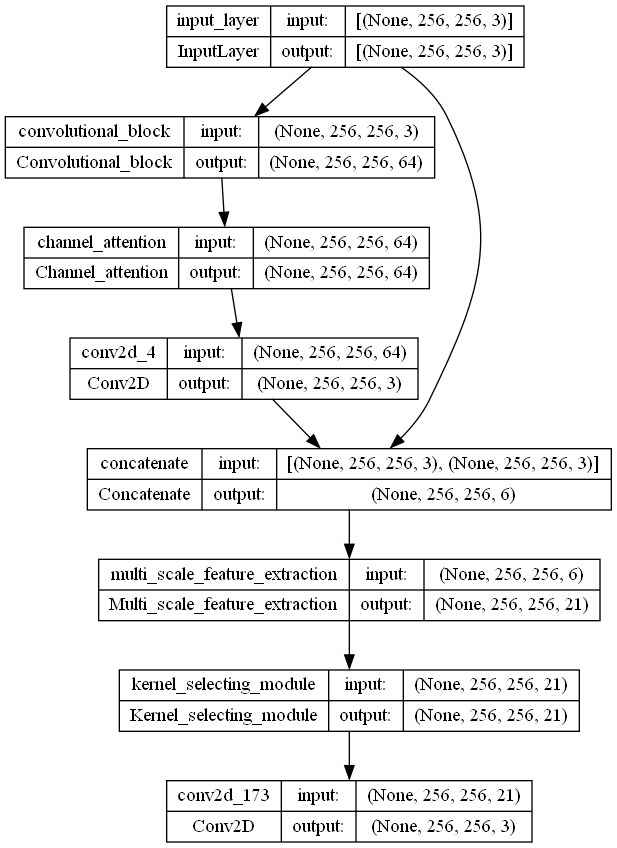

In [41]:
tf.keras.utils.plot_model(model=model, to_file='model_plot.png', show_shapes=True)

# Training

In [50]:
steps_per_epoch_train = len(noisy_train_images)
steps_per_epoch_validation = len(noisy_test_images)

In [51]:
best_models_path = "models/"
callbacks_lst = [
                 tf.keras.callbacks.ModelCheckpoint(filepath=best_models_path+"best_PRIDNet_blindnoise_256x256.h5", period=10, save_weights_only=False),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=0.0000009, min_delta=0.0001, factor=0.70, patience=3, verbose=1, mode='min'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, min_delta=0.0001, patience=10)
]

In [53]:
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=Adam(learning_rate=0.0009))
model.fit(image_generator_train, 
          validation_data=image_generator_test,
                        steps_per_epoch=steps_per_epoch_train,
                        validation_steps=steps_per_epoch_validation,
                        epochs=4,
                        verbose=1,
                        callbacks=callbacks_lst)

Epoch 1/4
100/100 [==============================] - 854s 8s/step - loss: 3.2797 - val_loss: 0.1432 - lr: 9.0000e-04
Epoch 2/4
100/100 [==============================] - 839s 8s/step - loss: 0.0950 - val_loss: 0.0629 - lr: 9.0000e-04
Epoch 3/4
100/100 [==============================] - 856s 9s/step - loss: 0.0470 - val_loss: 0.0342 - lr: 9.0000e-04
Epoch 4/4
100/100 [==============================] - 887s 9s/step - loss: 0.0269 - val_loss: 0.0206 - lr: 9.0000e-04


In [54]:
best_models_path = "models/"
model.save(best_models_path+"best_PRIDNet.h5")

# Predictions

In [42]:
# Inference
def inference_single_image(model, noisy_image):
    input_image = np.expand_dims(noisy_image, axis=0)
    predicted_image = model.predict(input_image)
    
    return predicted_image[0]

In [43]:
def inference_batch_images(model, noisy_images):
    predicted_image = model.predict(noisy_images)
    return predicted_image

In [47]:
from PIL import Image

In [89]:
def visualize_predictions(model, X_test, y_test, n):
#     random_numbers = random.choices(range(X_test.shape[0]), k=n)    # Get n random indices
    for i in range(10):
        noisy_image = X_test[i]
        gt_image = y_test[i]
        predicted_image = inference_single_image(model, X_test[i])
#         predicted_image/=255
        real_image = Image.fromarray((noisy_image * 255).astype(np.uint8))
        real_image.save("results/"+str(noisy_test_paths[i].split('\\')[-1])+".png")
        pred_image = Image.fromarray(np.clip(predicted_image * 255, 0, 255).astype(np.uint8))
        pred_image.save("results/"+str(noisy_test_paths[i].split('\\')[-1])+"_predicted.png")
        f, axarr = plt.subplots(1,3, figsize=(21,21))
        axarr[0].imshow(noisy_image)
        axarr[0].set_title("Noisy image")
        axarr[0].set_axis_off()
        axarr[1].imshow(gt_image)
        axarr[1].set_title("Ground truth image")
        axarr[1].set_axis_off()
        axarr[2].imshow(predicted_image)
        axarr[2].set_title("Predicted image")
        axarr[2].set_axis_off()

In [90]:
# best_models_path = "models/"
# model = tf.keras.models.load_model(best_models_path+'best_PRIDNet.h5', custom_objects={'Convolutional_block': Convolutional_block,
#                                                                                                         'Channel_attention':Channel_attention,
#                                                                                                         'Avg_pool_Unet_Upsample_msfe':Avg_pool_Unet_Upsample_msfe,
#                                                                                                         'Multi_scale_feature_extraction':Multi_scale_feature_extraction,
#                                                                                                         'Kernel_selecting_module':Kernel_selecting_module})

1/1 [==============================] - 0s 422ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 415ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 422ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 424ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 438ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 436ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 433ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 444ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 428ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 428ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


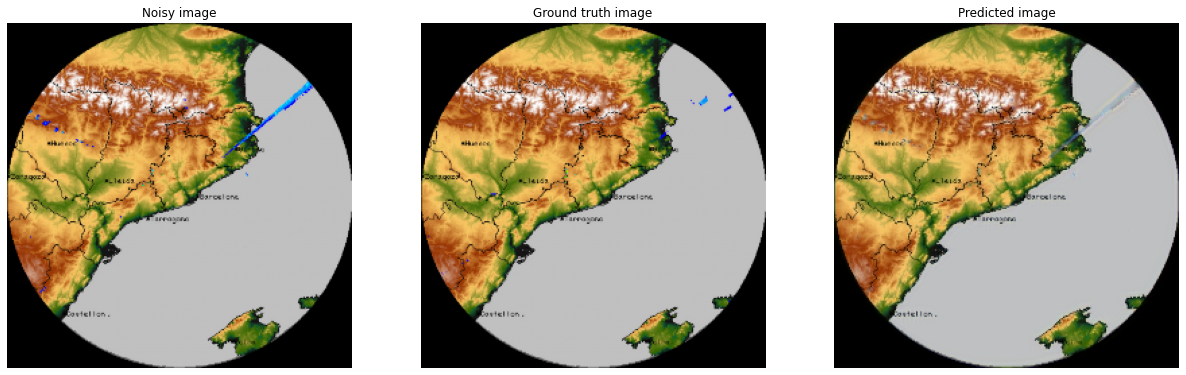

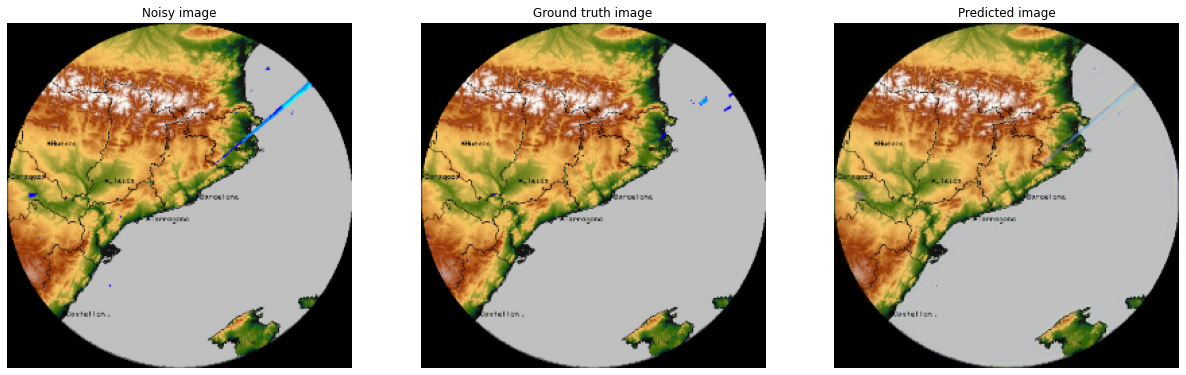

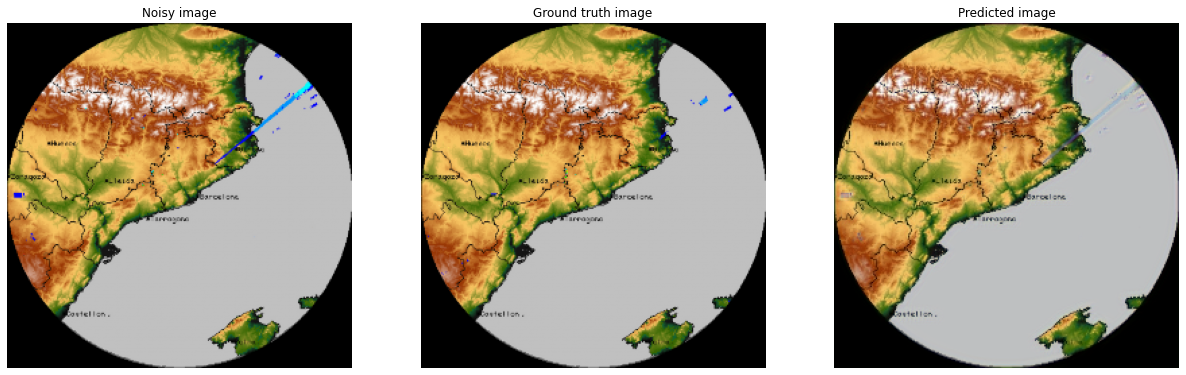

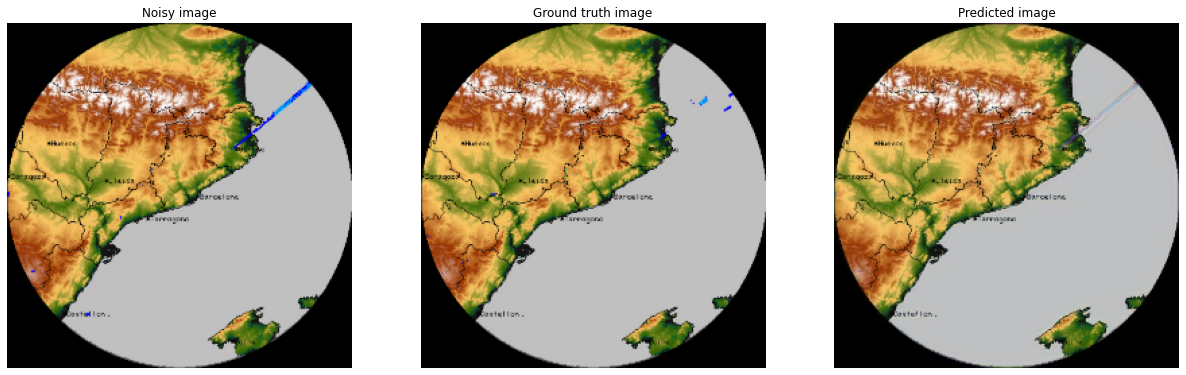

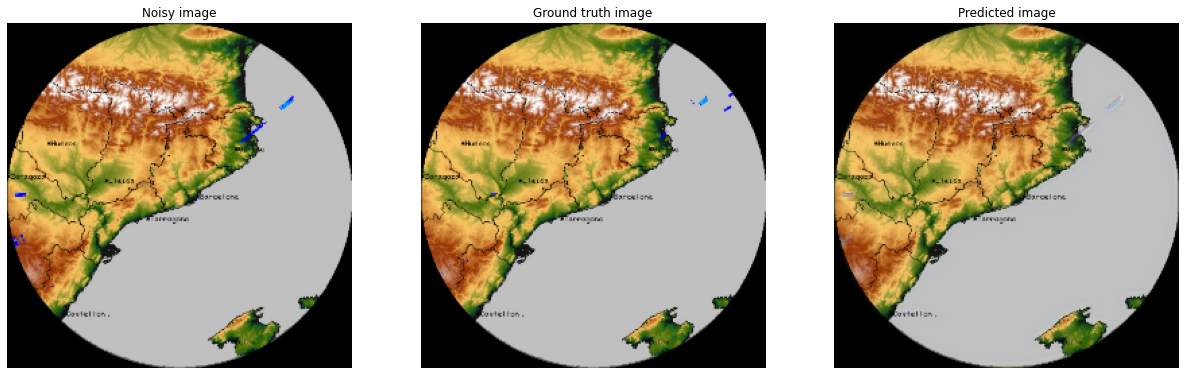

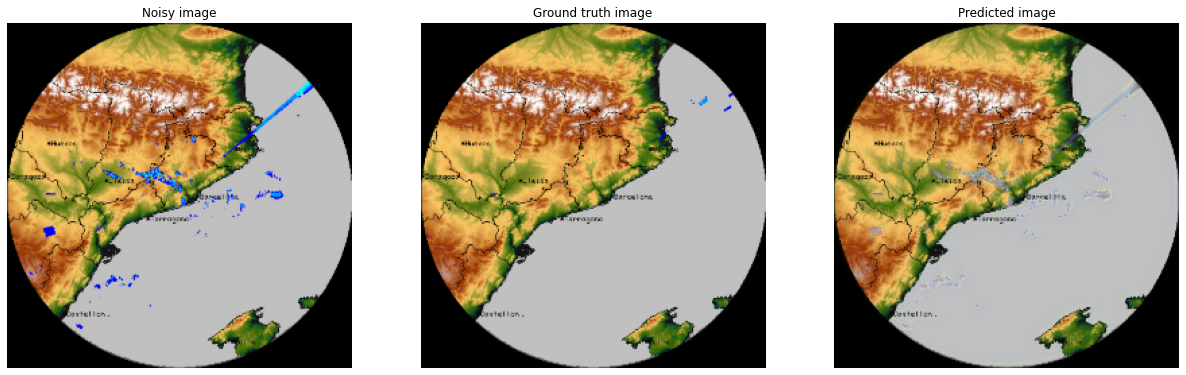

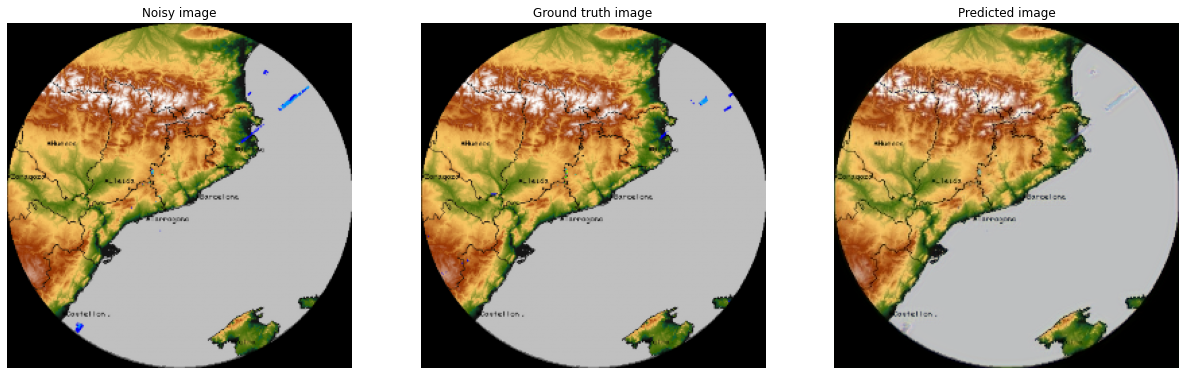

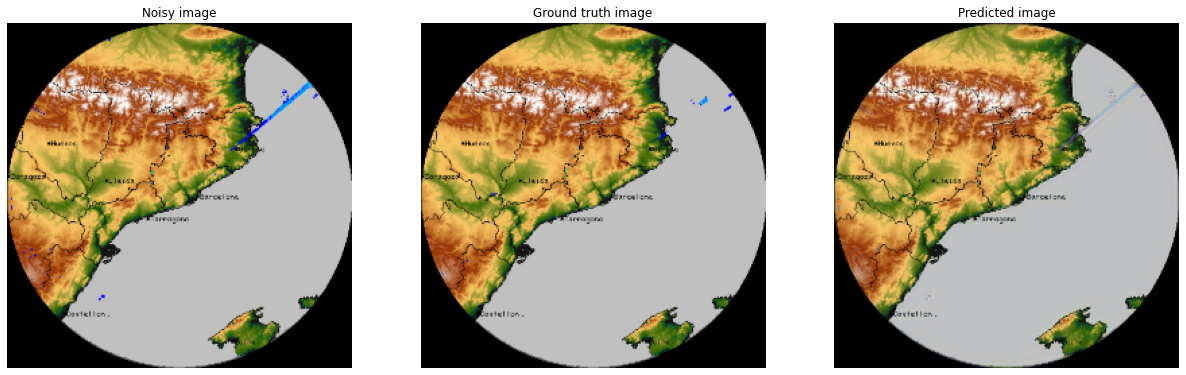

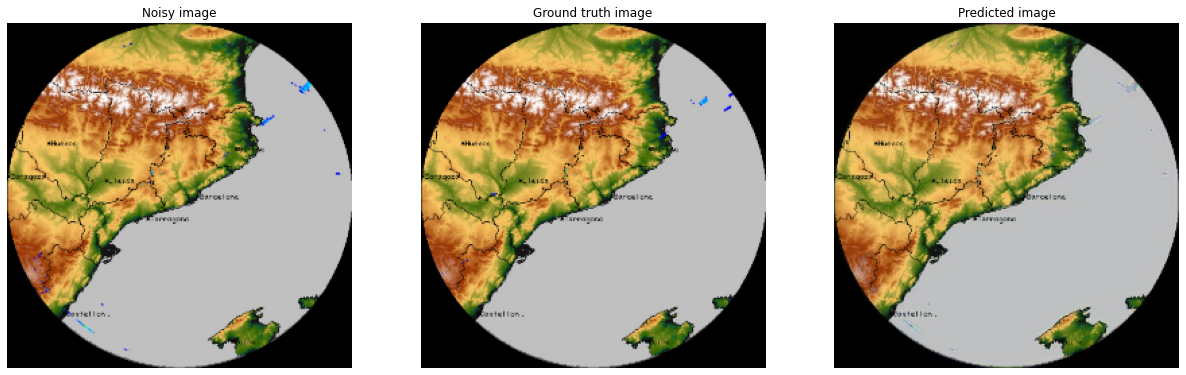

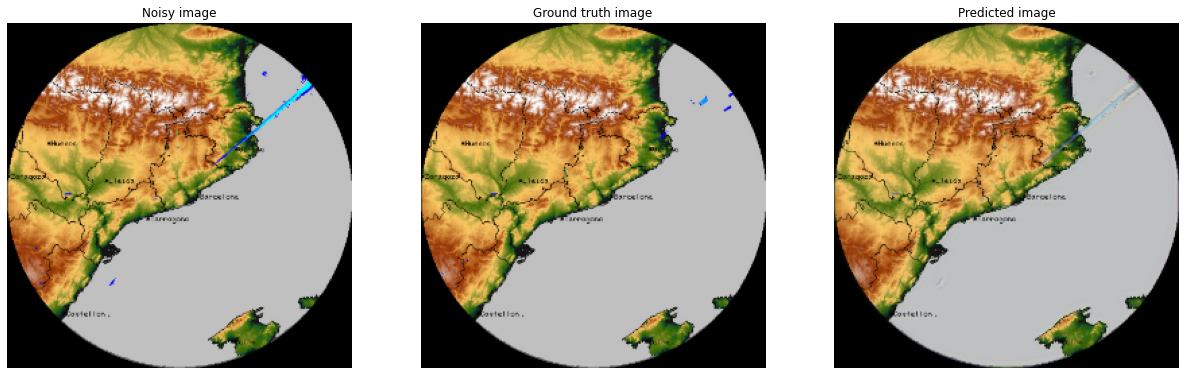

In [91]:
visualize_predictions(model, noisy_test_images, gt_test_images, 10)